# Operator evolution

__Author:__ A. J. Tropiano [tropiano.4@osu.edu]<br/>
__Date:__ January 7, 2020

Generates SRG operator evolution figures, based on this paper: A. J. Tropiano, S. K. Bogner, and R. J. Furnstahl, [Phys. Rev. C __102__, 034005 (2020)](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.102.034005). This notebook is split into two sections: __SRG evolution of NN potentials__ and __Evolution of other operators__.

_Last update:_ June 30, 2022

__To-do list:__
* Finish functions.
* Add markdown to cells in section.
* Call functions to generate plots and test.
* Add docstrings to functions.
* Repeat the above for each section.
* Update figures in dissertation.
* Add option for other sub-blocks of coupled-channel operators (e.g., $^{3}\rm{S}_1$-$^{3}\rm{D}_1$).

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la

In [2]:
# Imports from A.T. codes
from scripts.figures import (
    set_rc_parameters, interpolate_matrix, line_styles, xkcd_colors,
    label_channel, label_generator, label_kvnn, label_lambda, label_ticks
)
from scripts.fourier_transform import hankel_transformation_k2r
from scripts.integration import unattach_weights_from_vector
from scripts.phase_shifts import phase_shifts, coupled_channel_phase_shifts
from scripts.potentials import Potential
from scripts.sdt import correlation_coefficient
from scripts.srg import get_transformation
from scripts.tools import find_index, replace_periods
from scripts.wave_function import wave_function

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/operator_evolution/'

## SRG evolution of NN potentials

### Plotting functions

In [ ]:
def potential_contours_vary_kvnn(
        kvnns, channel, kmax, kmid, ntot, generator, lambdas,
        levels_number=61, colorbar_limits=(-1.0,1.0), color_map='turbo',
        axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16,
        kvnn_label=True, lambda_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = len(kvnns)
    col_number = len(lambdas)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4*row_number))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)
    
    # --- Get data --- #
    # Add a row for each kvnn
    for i, kvnn in enumerate(kvnns):
        
        # Initialize potential object and get its momentum mesh
        potential = Potential(kvnn, channel, kmax, kmid, ntot)
        k_array, _ = potential.load_mesh()
    
        # Interpolate/plot up to this value
        k_max = axes_limits[1] + 0.2
    
        # Add a column for each \lambda or \Lambda_BD value
        for j, lamb in enumerate(lambdas):
    
            # Initial potential
            if lamb == np.inf:
                V_matrix = potential.load_potential()
            # SRG-evolved with block-diagonal generator
            elif generator == 'Block-diag':
                V_matrix = potential.load_potential('srg', generator, 1.0,
                                                    lamb)
            # SRG-evolved with band-diagonal generators
            else:
                V_matrix = potential.load_potential('srg', generator, lamb)
    
            # If coupled-channel, then plot the lower L-L block
            if potential.coupled_channel_bool:
                V_matrix = V_matrix[:ntot,:ntot]

            # Interpolate potential for high resolution contour figure
            k_array_dense, _, V_matrix_dense = interpolate_matrix(
                k_array, k_array, V_matrix, k_max, k_max)

            # --- Plot --- #
            c = axs[i, j].contourf(
                k_array_dense, k_array_dense, V_matrix_dense, levels,
                cmap=color_map, extend='both')

            # --- Axes limits --- #
            axs[i, j].set_xlim(axes_limits)
            axs[i, j].set_ylim(axes_limits)

            # --- Axes labels --- #
            # Label x-axis for top row only
            if i == 0:
                axs[i, j].set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]",
                                     fontsize=xlabel_size)
            
            # Label y-axis for left column only
            if j == 0: 
                axs[i, j].set_ylabel("$k$ [fm" + r"$^{-1}$" + "]",
                                     fontsize=ylabel_size)
    
            # --- Adjust axes --- #
            # Switch x-axis label from bottom to top (top row only)
            if i == 0:
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].tick_params(labeltop=True, labelbottom=False)
            else:  # No tick labels on the bottom row x-axes
                axs[i, j].tick_params(labelbottom=False)
            # Invert y-axis
            axs[i, j].invert_yaxis()

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.05, wspace=0.05)
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((0.9+0.1/col_number, 0.15, 0.1/col_number, 0.7))
    # Set colorbar ticks and tick labels
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    levels_ticks_strings = label_ticks(levels_ticks)  # Make these strings
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.set_yticklabels(levels_ticks_strings)
    cbar.ax.set_title("[fm]", fontsize=16, pad=15)

    # --- Additional labels --- #
    if kvnn_label:  # Label potential in last column
        for i, ikvnn in enumerate(kvnns):
            axs[i, -1].add_artist(
                AnchoredText(label_kvnn(ikvnn, full_label=False),
                             loc='upper right', prop=dict(size=20))
            )
        
    if lambda_label:  # Label \lambda or \Lambda_BD in all sub-plots
        for i in range(row_number):
            for j, jlamb in enumerate(lambdas):
                axs[i, j].add_artist(
                    AnchoredText(label_lambda(jlamb, generator),
                                 loc='lower left', prop=dict(size=18))
                )

    # --- Save file --- #
    if save:
        file_name = 'potential_contours_kvnns'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        file_name += (f'_{channel}_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}'
                      f'_{generator}')
        for ilamb in lambdas:
            file_name += f'_{ilamb}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [ ]:
def potential_contours_vary_generator(
        kvnn, channel, kmax, kmid, ntot, generators, lambdas,
        levels_number=61, colorbar_limits=(-1.0,1.0), color_map='turbo',
        axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16,
        generator_label=True, lambda_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = len(generators)
    col_number = len(lambdas)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4*row_number))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)
    
    # --- Get data --- #
    # Initialize potential object and get its momentum mesh
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    k_array, _ = potential.load_mesh()
    
    # Interpolate/plot up to this value
    k_max = axes_limits[1] + 0.2
    
    # Add a row for each SRG generator
    for i, generator in enumerate(generators):
        # Add a column for each \lambda or \Lambda_BD value
        for j, lamb in enumerate(lambdas):
    
            # Initial potential
            if lamb == np.inf:
                V_matrix = potential.load_potential()
            # SRG-evolved with block-diagonal generator
            elif generator == 'Block-diag':
                V_matrix = potential.load_potential('srg', generator, 1.0,
                                                    lamb)
            # SRG-evolved with band-diagonal generators
            else:
                V_matrix = potential.load_potential('srg', generator, lamb)
    
            # If coupled-channel, then plot the lower L-L block
            if potential.coupled_channel_bool:
                V_matrix = V_matrix[:ntot,:ntot]

            # Interpolate potential for high resolution contour figure
            k_array_dense, _, V_matrix_dense = interpolate_matrix(
                k_array, k_array, V_matrix, k_max, k_max)

            # --- Plot --- #
            c = axs[i, j].contourf(
                k_array_dense, k_array_dense, V_matrix_dense, levels,
                cmap=color_map, extend='both')

            # --- Axes limits --- #
            axs[i, j].set_xlim(axes_limits)
            axs[i, j].set_ylim(axes_limits)

            # --- Axes labels --- #
            # Label x-axis for top row only
            if i == 0:
                axs[i, j].set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]",
                                     fontsize=xlabel_size)
            
            # Label y-axis for left column only
            if j == 0: 
                axs[i, j].set_ylabel("$k$ [fm" + r"$^{-1}$" + "]",
                                     fontsize=ylabel_size)
    
            # --- Adjust axes --- #
            # Switch x-axis label from bottom to top (top row only)
            if i == 0:
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].tick_params(labeltop=True, labelbottom=False)
            else:  # No tick labels on the bottom row x-axes
                axs[i, j].tick_params(labelbottom=False)
            # Invert y-axis
            axs[i, j].invert_yaxis()

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.05, wspace=0.05)
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((0.9+0.1/col_number, 0.15, 0.1/col_number, 0.7))
    # Set colorbar ticks and tick labels
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    levels_ticks_strings = label_ticks(levels_ticks)  # Make these strings
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.set_yticklabels(levels_ticks_strings)
    cbar.ax.set_title("[fm]", fontsize=16, pad=15)

    # --- Additional labels --- #
    if generator_label:  # Label SRG generator in last column
        for i, igenerator in enumerate(generators):
            axs[i, -1].add_artist(
                AnchoredText(label_generator(igenerator), loc='upper right',
                             prop=dict(size=20))
            )
        
    if lambda_label:  # Label \lambda or \Lambda_BD in all sub-plots
        for i, igenerator in enumerate(generators):
            for j, jlamb in enumerate(lambdas):
                axs[i, j].add_artist(
                    AnchoredText(label_lambda(jlamb, igenerator),
                                 loc='lower left', prop=dict(size=18))
                )

    # --- Save file --- #
    if save:
        file_name = (f'potential_contours_kvnn_{kvnn}_{channel}_kmax_{kmax}'
                     f'_kmid_{kmid}_ntot_{ntot}')
        for igenerator in generators:
            file_name += f'_{igenerator}'
        for ilamb in lambdas:
            file_name += f'_{ilamb}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [ ]:
def compare_phase_shifts(
        kvnns, channel, kmax, kmid, ntot, x_limits=(0,4), y_limits=(-50,180),
        xlabel_size=16, ylabel_size=16, channel_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))

    # --- Get data --- #
    # Set array for k values [fm^-1] (take 200 points)
    k_points = np.linspace(0.01, x_limits[1], 200)

    # Conversion to E_lab
    e_array = 2.0*41.47*k_points**2
    
    for i, kvnn in enumerate(kvnns):
        
        # Get potential and its momentum mesh
        potential = Potential(kvnn, channel, kmax, kmid, ntot)
        V_matrix = potential.load_potential()
        k_array, k_weights = potential.load_mesh()

        # Calculate phase shifts
        # If coupled-channel, use the Stapp convention
        if potential.coupled_channel_bool:
            phase_shifts_array = coupled_channel_phase_shifts(
                e_array, V_matrix, k_array, k_weights, convention='Stapp')
            # Take only delta_a_array (excludes delta_b and epsilon)
            delta_array = phase_shifts_array[:, 0]
        else:
            delta_array = phase_shifts(e_array, V_matrix, k_array, k_weights)

        # --- Set data labels --- #
        # Different color and linestyle for each kvnn
        curve_color = xkcd_colors(i)
        curve_style = line_styles(i)
        curve_label = label_kvnn(kvnn, full_label=False)

        # --- Plot --- #
        ax.plot(k_points, delta_array, color=curve_color, label=curve_label,
                linestyle=curve_style, linewidth=2.0)

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("$\delta$ [deg]", fontsize=ylabel_size)

    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=16, frameon=False)  # Label kvnns

    # --- Additional labels --- #
    if channel_label:  # Label partial wave channel
        ax.add_artist(
            AnchoredText(label_channel(channel, label_coupled_channel=False),
                         frameon=False, loc='lower left', prop=dict(size=22))
        )

    # --- Save file --- #
    if save:
        file_name = 'phase_shifts_kvnns'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        file_name += f'_{channel}_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [ ]:
def potential_slices(
        kvnns, channel, kmax, kmid, ntot, generators, lambdas, 
        x_limits=(0.0,4.0), y_limits=(-4.0,2.0), xlabel_size=16,
        ylabel_size=16, channel_label=True, save=False):
    """
    Plots the diagonal and far off-diagonal matrix elements of SRG-evolved
    potentials with respect to k as a multi-column plot. Each column
    corresponds to different \lambda and \Lambda_BD values.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers that specify a set of potentials.
    channel : str
        The partial wave channel (e.g. '1S0').
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    generators : tuple
        SRG generators (e.g., ('Wegner', 'Block-diag')).
    lambdas : tuple
        SRG evolution parameters \lambda and \Lambda_BD [fm^-1]. For block-
        diagonal decoupling, \lambda=1.2 fm^-1.
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [fm].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    channel_label : bool, optional
        Option to add a channel label on the figure as an anchored text.
    save : bool, optional
        Option to save the figure.
    
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = 2
    col_number = len(lambdas)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4*row_number))
    
    # Set off-diagonal k value depending on channel
    if channel in ('1S0', '3S1'):
        k_od_value = 0
    else:
        k_od_value = 0.5
    
    # --- Get data --- #  
    for i, kvnn in enumerate(kvnns):
        
        # Initialize potential object and get its momentum mesh
        potential = Potential(kvnn, channel, kmax, kmid, ntot)
        k_array, _ = potential.load_mesh()
        
        # Index of off-diagonal k value in k_array
        k_od_index = find_index(k_od_value, k_array)
        
        for j, generator in enumerate(generators):
            
            # Add a sub-plot for each \lambda and \Lambda_BD value
            for k, lamb in enumerate(lambdas):
            
                # Initial potential
                if lamb == np.inf:
                    V_matrix = potential.load_potential()
                # SRG-evolved with block-diagonal generator
                elif generator == 'Block-diag':
                    V_matrix = potential.load_potential('srg', generator, 1.0,
                                                        lamb)
                # SRG-evolved with band-diagonal generators
                else:
                    V_matrix = potential.load_potential('srg', generator,
                                                        lamb)
    
                # If coupled-channel, then plot the lower L-L block
                if potential.coupled_channel_bool:
                    V_matrix = V_matrix[:ntot,:ntot]
                    
                # --- Set data labels --- #
                # Different color for each kvnn
                curve_color = xkcd_colors(i)

                # Different linestyle for each generator
                curve_style = line_styles(j)

                # Label kvnn for Wegner generator only
                if j == 0:
                    kvnn_label = label_kvnn(kvnn, full_label=False)
                else:
                    kvnn_label = ''
                
                # Label generator for first kvnn only
                if i == 0:
                    generator_label = label_generator(generator)
                else:
                    generator_label = ''
                
                # --- Plot --- #
                # Plot diagonal matrix elements on top row and label kvnn
                axs[0, k].plot(
                    k_array, np.diag(V_matrix), color=curve_color,
                    label=kvnn_label, linestyle=curve_style, linewidth=2.0)
                
                # Plot off-diagonal matrix elements on bottom row and label
                # the SRG generator
                axs[1, k].plot(
                    k_array, V_matrix[:, k_od_index], color=curve_color,
                    label=generator_label, linestyle=curve_style,
                    linewidth=2.0)

                # --- Axes limits --- #
                axs[0, k].set_xlim(x_limits)
                axs[0, k].set_ylim(y_limits)
                axs[1, k].set_xlim(x_limits)
                axs[1, k].set_ylim(y_limits)
                    
                # --- Axes labels --- #
                # Label x-axis on bottom row
                axs[1, k].set_xlabel("$k$ [fm" + r"$^{-1}$" + "]",
                                     fontsize=xlabel_size)
                    
    # Label y-axis on left column
    axs[0, 0].set_ylabel(r"$V(k,k)$ [fm]", fontsize=ylabel_size)
    axs[1, 0].set_ylabel(rf"$V(k,{k_od_value})$ [fm]", fontsize=ylabel_size)

    # --- Adjust axes --- #                      
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.05, wspace=0.05)

    # --- Legends --- #
    # Label kvnns on top row
    axs[0, 0].legend(loc='lower right', fontsize=18, frameon=False)
    # Label generators on bottom row
    axs[-1, 0].legend(loc='lower right', fontsize=18, frameon=False)

    # --- Additional labels --- #
    # Label partial wave channel in last sub-plot
    if channel_label:
        axs[-1, -1].add_artist(
            AnchoredText(label_channel(channel, label_coupled_channel=False),
                         frameon=False, loc='lower right',
                         prop=dict(size=24))
            )
    
    # Label both \lambda and \Lambda_BD values on each sub-plot
    for irow in range(row_number):
        for i, ilamb in enumerate(lambdas):
            if ilamb == np.inf:
                lambda_label = (r"$\lambda$, $\Lambda_{\rm{BD}}=\infty$"
                                r" fm$^{-1}$")
            else:
                lambda_label = (
                    rf"$\lambda$, $\Lambda_{{\rm{{BD}}}}={ilamb:.1f}$"
                    r" fm$^{{-1}}$"
                )
            axs[irow, i].add_artist(
                AnchoredText(lambda_label, frameon=False, loc='upper left',
                             prop=dict(size=17))
            )

    # --- Save file --- #
    if save:
        file_name = 'potential_slices_kvnns'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        file_name += f'_{channel}_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}'
        for igenerator in generators:
            file_name += f'_{igenerator}'
        for ilamb in lambdas:
            file_name += f'_{ilamb}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [ ]:
def universality_matrix_norms(
        kvnns, channels, kmax, kmid, ntot, generator, lambdas,
        x_limits=(0.0,7.0), y_limits=(8e-4,2e0), xlabel_size=16,
        ylabel_size=16, generator_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    col_number = len(kvnns)
    f, axs = plt.subplots(1, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4))

    # --- Get data --- #
    # Store data in dictionary
    d = {}
    for i, channel in enumerate(channels):
        
        d[channel] = {}

        for j, lamb in enumerate(lambdas):
            
            d[channel][lamb] = {}
            
            # Set average matrix norm to divide by (should scale with
            # truncation so we don't see decrease solely from truncating at
            # smaller values of k)
            average_norm = 0.0

            # Compute average norm of all potentials
            for kvnn in kvnns:
                
                # Get momentum array
                potential = Potential(kvnn, channel, kmax, kmid, ntot)
                k_array, _ = potential.load_mesh()
                
                # Get SRG-evolved potential
                if generator == 'Block-diag':
                    V_matrix = potential.load_potential('srg', generator, 1.0,
                                                        lamb)
                else:
                    V_matrix = potential.load_potential('srg', generator,
                                                        lamb)
                    
                # Truncate potential at k,k' = \lambda (or \Lambda_BD)
                k_index = find_index(lamb, k_array)
                V_truncated = V_matrix[:k_index, :k_index]
                
                # Add truncated potential to dictionary
                d[channel][lamb][kvnn] = V_truncated
                
                # Add to average norm
                average_norm += la.norm(V_truncated) / col_number
                
            # Store average norm in dictionary
            d[channel][lamb]['norm'] = average_norm
            
    # Compute the norm of the difference in pairs of potentials
    for i, ikvnn in enumerate(kvnns):
        
        # This sets the second kvnn of the pair
        j = (i+1) % col_number
        jkvnn = kvnns[j]
        
        for k, channel in enumerate(channels):
            
            # Initialize array for ||\Delta V_\lambda(k,k')||
            norm_diff_array = np.zeros_like(lambdas)
            
            for l, lamb in enumerate(lambdas):
                
                delta_V = d[channel][lamb][ikvnn] - d[channel][lamb][jkvnn]
                norm_diff_array[l] = (la.norm(delta_V)
                                      / d[channel][lamb]['norm'])

            # --- Set data labels --- #
            curve_label = label_channel(channel, label_coupled_channel=False)
            curve_color = xkcd_colors(k)

            # --- Plot --- #
            axs[i].semilogy(
                lambdas, norm_diff_array, color=curve_color,
                label=curve_label, linestyle='dotted', linewidth=2.0,
                marker='o'
            )
                
        # --- Axes limits --- #
        axs[i].set_xlim(x_limits)
        axs[i].set_ylim(y_limits)

    # --- Axes labels --- #
    axs[0].set_ylabel(r"$||\Delta V(k,k')||$", fontsize=ylabel_size)
    for ax in axs:
        if generator == 'Block-diag':
            lamb_label = r"$\Lambda_{\rm{BD}}$ [fm" + r"$^{-1}$" + "]"
        else:
            lamb_label = r"$\lambda$ [fm" + r"$^{-1}$" + "]"
        ax.set_xlabel(lamb_label, fontsize=xlabel_size)

    # --- Adjust axes --- #                      
    # Amount of white space in-between sub-plots
    f.subplots_adjust(wspace=0.05)

    # --- Legend --- #
    # Label channels
    axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                   borderaxespad=0.0, fontsize=16)

    # --- Additional labels --- #
    for i, ikvnn in enumerate(kvnns):  # Label pairs of potentials on each plot
        j = (i+1) % col_number
        jkvnn = kvnns[j]
        pair_label = (label_kvnn(ikvnn, full_label=False) + '\n'
                      +label_kvnn(jkvnn, full_label=False))
        axs[i].add_artist(
            AnchoredText(pair_label, frameon=False, loc='lower right',
                         prop=dict(size=18))
        )
        
    if generator_label:  # Label SRG generator on first sub-plot
        axs[0].add_artist(
            AnchoredText(label_generator(generator), frameon=False,
                         loc='lower left', prop=dict(size=18))
        )

    # --- Save file --- #
    if save:
        file_name = 'universality_matrix_norms_kvnns'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}'
        for ilamb in lambdas:
            file_name += f'_{ilamb}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [ ]:
def universality_sdt_angle(
        kvnns, channels, kmax, kmid, ntot, generator, lambdas,
        x_limits=(0.0,7.0), y_limits=(-5.0, 95.0), xlabel_size=16,
        ylabel_size=16, generator_label=True, save=False):
    """
    """

    # --- Figure set-up --- #
    plt.close('all')
    col_number = len(kvnns)
    f, axs = plt.subplots(1, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4))

    # --- Get data --- #
    # Store each potential in dictionary
    d = {}
    for kvnn in kvnns:
        d[kvnn] = {}
        for channel in channels:
            
            d[kvnn][channel] = {}
            
            # Get momentum array
            potential = Potential(kvnn, channel, kmax, kmid, ntot)
            k_array, k_weights = potential.load_mesh()
            
            for lamb in lambdas:

                # Get SRG-evolved potential
                if generator == 'Block-diag':
                    V_matrix = potential.load_potential('srg', generator, 1.0,
                                                        lamb)
                else:
                    V_matrix = potential.load_potential('srg', generator,
                                                        lamb)
                    
                # Truncate potential at k,k' = \lambda (or \Lambda_BD)
                k_index = find_index(lamb, k_array)
                V_truncated = V_matrix[:k_index, :k_index]
                k_array_truncated = k_array[:k_index]
                k_weights_truncated = k_weights[:k_index]
                
                # Add truncated potential and mesh to dictionary
                d[kvnn][channel][lamb] = (
                    V_truncated, k_array_truncated, k_weights_truncated
                )
    
    for i, ikvnn in enumerate(kvnns):
        
        # This sets the second kvnn of the pair
        j = (i+1) % col_number
        jkvnn = kvnns[j]
        
        for k, channel in enumerate(channels):
            
            # Initialize array for ||\theta_{V,V'}||
            angles_array = np.zeros_like(lambdas)
            
            for l, lamb in enumerate(lambdas):
                
                # Get data from dictionary
                V_matrix, k_array, k_weights = d[ikvnn][channel][lamb]
                Vp_matrix, _, _ = d[jkvnn][channel][lamb]
                
                # Compute correlation coefficient angle
                coefficient = correlation_coefficient(V_matrix, Vp_matrix,
                                                      k_array, k_weights)
                angles_array[l] = np.degrees(np.arccos(coefficient))
        
            # --- Set data labels --- #
            curve_label = label_channel(channel, label_coupled_channel=False)
            curve_color = xkcd_colors(k)

            # --- Plot --- #
            axs[i].plot(
                lambdas, angles_array, color=curve_color, label=curve_label,
                linestyle='dotted', linewidth=2.0, marker='o'
            )
                
        # --- Axes limits --- #
        axs[i].set_xlim(x_limits)
        axs[i].set_ylim(y_limits)

    # --- Axes labels --- #
    axs[0].set_ylabel(r"$\theta_{V,V'}$ [deg]", fontsize=ylabel_size)
    for ax in axs:
        if generator == 'Block-diag':
            lamb_label = r"$\Lambda_{\rm{BD}}$ [fm" + r"$^{-1}$" + "]"
        else:
            lamb_label = r"$\lambda$ [fm" + r"$^{-1}$" + "]"
        ax.set_xlabel(lamb_label, fontsize=xlabel_size)

    # --- Adjust axes --- #                      
    # Amount of white space in-between sub-plots
    f.subplots_adjust(wspace=0.05)

    # --- Legend --- #
    # Label channels
    axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                   borderaxespad=0.0, fontsize=16)

    # --- Additional labels --- #
    for i, ikvnn in enumerate(kvnns):  # Label pairs of potentials on each plot
        j = (i+1) % col_number
        jkvnn = kvnns[j]
        pair_label = (label_kvnn(ikvnn, full_label=False) + '\n'
                      +label_kvnn(jkvnn, full_label=False))
        axs[i].add_artist(
            AnchoredText(pair_label, frameon=False, loc='upper left',
                         prop=dict(size=18))
        )
        
    if generator_label:  # Label SRG generator on first sub-plot
        axs[0].add_artist(
            AnchoredText(label_generator(generator), frameon=False,
                         loc='center left', prop=dict(size=18))
        )

    # --- Save file --- #
    if save:
        file_name = 'universality_sdt_angle_kvnns'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}'
        for ilamb in lambdas:
            file_name += f'_{ilamb}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [44]:
def deuteron_wf_rspace(
        kvnns, kmax, kmid, ntot, generator, lamb, x_limits=(0,5),
        y_limits=(-0.2,0.55), xlabel_size=16, ylabel_size=16,
        generator_label=True, save=False):
    """
    """

    # --- Figure set-up --- #
    plt.close('all')
    col_number = 2
    f, axs = plt.subplots(1, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4))
    
    # Add an inset plot for spurious bound state potential in initial panel
    if (901 in kvnns or 902 in kvnns):
        spurious_state = True
        left, bottom, width, height = (0.34, 0.55, 0.15, 0.3)
        inset_ax = f.add_axes([left, bottom, width, height])
    else:
        spurious_state = False

    # --- Get data --- #
    # Channel is 3S1-3D1 for deuteron
    channel = '3S1'
    
    # Set-up position array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)

    for i, kvnn in enumerate(kvnns):
        
        # Initialize potential object and get its momentum mesh
        potential = Potential(kvnn, channel, kmax, kmid, ntot)
        k_array, k_weights = potential.load_mesh()
        
        # Get initial and evolved Hamiltonians
        H_initial = potential.load_hamiltonian('initial')
        if generator == 'Block-diag':
            H_evolved = potential.load_hamiltonian('srg', generator, 1.0,
                                                   lamb)
        else:
            H_evolved = potential.load_hamiltonian('srg', generator, lamb)

        # Calculate unitary transformation
        U_matrix = get_transformation(H_initial, H_evolved)

        # Get initial and evolved deuteron wave functions in momentum space
        psi_initial_unitless = wave_function(H_initial, -2.22)
        psi_evolved_unitless = wave_function(H_initial, -2.22, U_matrix)
        
        # Divide out the integration measure in each wave function [fm^3/2]
        psi_initial = unattach_weights_from_vector(
            k_array, k_weights, psi_initial_unitless, coupled_channel=True)
        psi_evolved = unattach_weights_from_vector(
            k_array, k_weights, psi_evolved_unitless, coupled_channel=True)
        
        # Load Hankel transformations for 3S1 and 3D1 channels
        hank_trans_s = hankel_transformation_k2r(0, k_array, k_weights,
                                                 r_array)
        hank_trans_d = hankel_transformation_k2r(2, k_array, k_weights,
                                                 r_array)
        
        # Sign factor (not sure why some potentials give opposite sign)
        if kvnn in (6, 900, 901, 902):  # Might be the momentum mesh?
            sign = -1
        else:
            sign = 1
        
        # Get S- and D-states in coordinate space
        s_initial = hank_trans_s @ psi_initial[:ntot]
        d_initial = hank_trans_d @ psi_initial[ntot:]
        s_evolved = hank_trans_s @ psi_evolved[:ntot]
        d_evolved = hank_trans_d @ psi_evolved[ntot:]
        
        # Rough way for correcting sign of wave function (not sure why some
        # potentials give the opposite sign)
        if s_initial[ntot-10] < 0.0:
            sign = -1
        else:
            sign = 1

        # --- Set data labels --- #
        curve_color = xkcd_colors(i)

        # --- Plot --- #
        # Initial wave functions on left sub-plot
        axs[0].plot(
            r_array, s_initial*sign, color=curve_color, linestyle='solid',
            linewidth=2.0, label=label_kvnn(kvnn, full_label=False)
        )
        axs[0].plot(
            r_array, d_initial*sign, color=curve_color, linestyle='dashed',
            linewidth=2.0, label=''
        )
        
        # Evolved wave functions on right sub-plot
        axs[1].plot(
            r_array, s_evolved*sign, color=curve_color, linestyle='solid',
            linewidth=2.0, label=label_kvnn(kvnn, full_label=False)
        )
        axs[1].plot(
            r_array, d_evolved*sign, color=curve_color, linestyle='dashed',
            linewidth=2.0, label=''
        )
        
        # --- Plot final features --- #
        # Inset plot (only if we have a spurious state potential)
        if spurious_state:

            inset_ax.plot(r_array, s_initial*sign, color=curve_color,
                          linestyle='solid', linewidth=2.0)
            inset_ax.plot(r_array, d_initial*sign, color=curve_color,
                          linestyle='dashed', linewidth=2.0)
            inset_ax.set_xlim(0.0, 2.0)  # Shortened x-axis
            # Extended y-axis to see negative drop
            inset_ax.set_ylim(-0.7, 0.5)
            
    # Add horizontal line at psi_d = 0 fm^-3/2
    axs[0].axhline(0.0, color='gray', alpha=0.4, zorder=1)
    axs[1].axhline(0.0, color='gray', alpha=0.4, zorder=1)

    # --- Axes limits --- #
    axs[0].set_xlim(x_limits)
    axs[0].set_ylim(y_limits)
    axs[1].set_xlim(x_limits)
    axs[1].set_ylim(y_limits)

    # --- Axes labels --- #
    axs[0].set_ylabel(r"$\psi_d(r)$ [fm" + r"$^{-3/2}$" + "]",
                      fontsize=ylabel_size)
    for ax in axs:
        ax.set_xlabel(r"$r$ [fm]", fontsize=xlabel_size)

    # --- Adjust axes --- #
    # Amount of white space in-between sub-plots
    f.subplots_adjust(wspace=0.05)
    
    # --- Legend --- #
    if spurious_state:
        axs[1].legend(loc='upper right', fontsize=14, frameon=False)
    else:
        axs[0].legend(loc='upper right', fontsize=14, frameon=False)

    # --- Additional labels --- #
    # Add \lambda labels
    axs[0].add_artist(
        AnchoredText(label_lambda(np.inf, generator), frameon=False,
                     loc='lower right', prop=dict(size=18))
    )
    axs[1].add_artist(
        AnchoredText(label_lambda(lamb, generator), frameon=False,
                     loc='lower right', prop=dict(size=18))
    )

    if generator_label:  # Label SRG generator on second sub-plot
        if spurious_state:  
            generator_label_loc = 'center left'
        else:
            generator_label_loc = 'upper right'
        axs[1].add_artist(
            AnchoredText(label_generator(generator), frameon=False,
                         loc=generator_label_loc, prop=dict(size=20))
        )

    # --- Save file --- #
    if save:
        file_name = 'deuteron_wf_rspace_kvnns'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}'
                      f'_{lamb}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

### Modern chiral NN potentials

In [ ]:
kvnns = (79, 111, 222)
channel = '3S1'
kmax, kmid, ntot = 10.0, 2.0, 120
generator = 'Wegner'
lambdas = (np.inf, 3.0, 2.0, 1.5)

In [ ]:
potential_contours_vary_kvnn(kvnns, channel, kmax, kmid, ntot, generator,
                             lambdas, save=True)

In [ ]:
kvnn = 111
channel = '1P1'
kmax, kmid, ntot = 10.0, 2.0, 120
generators = ('Wegner', 'Block-diag')
lambdas = (np.inf, 3.0, 2.0, 1.5)

In [ ]:
potential_contours_vary_generator(
    kvnn, channel, kmax, kmid, ntot, generators, lambdas,
    colorbar_limits=(-0.4,0.4), save=True
)

In [ ]:
kvnns = (79, 111, 222)
channel = '3S1'
kmax, kmid, ntot = 10.0, 2.0, 120
generators = ('Wegner', 'Block-diag')
lambdas = (np.inf, 3.0, 1.5, 1.0)

In [ ]:
compare_phase_shifts(kvnns, channel, kmax, kmid, ntot, save=True)

In [ ]:
potential_slices(kvnns, channel, kmax, kmid, ntot, generators, lambdas,
                 save=True)

### Quantifying universality

In [ ]:
kvnns = (79, 111, 222)
channels = ('1S0', '3S1', '1P1', '1F3', '1G4')
kmax, kmid, ntot = 10.0, 2.0, 120
lambdas = (6.0, 3.0, 2.0, 1.5, 1.0)

In [ ]:
universality_matrix_norms(kvnns, channels, kmax, kmid, ntot, 'Wegner',
                          lambdas, save=True)

In [ ]:
universality_matrix_norms(kvnns, channels, kmax, kmid, ntot, 'Block-diag',
                          lambdas, save=True)

In [ ]:
universality_sdt_angle(kvnns, channels, kmax, kmid, ntot, 'Wegner', lambdas,
                       save=True)

In [ ]:
universality_sdt_angle(kvnns, channels, kmax, kmid, ntot, 'Block-diag',
                       lambdas, save=True)

### Evolved wave functions and SRCs

In [45]:
kvnns = (79, 111, 222)
kmax, kmid, ntot = 10.0, 2.0, 120
generator = 'Wegner'
lamb = 1.2

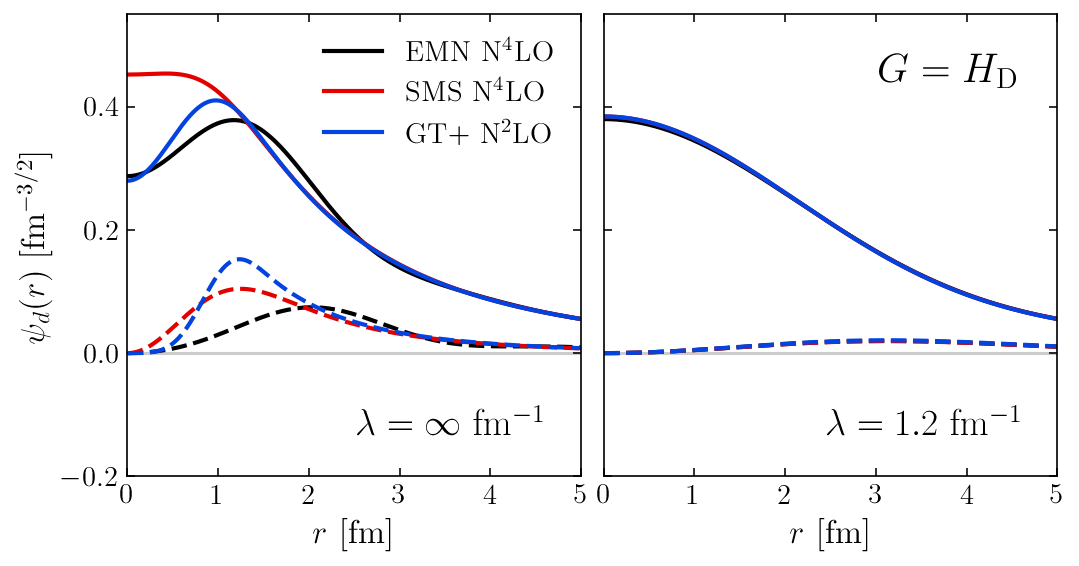

In [46]:
deuteron_wf_rspace(kvnns, kmax, kmid, ntot, generator, lamb, save=True)

In [47]:
kvnns = (6, 900, 901)
kmax, kmid, ntot = 30.0, 4.0, 120
generator = 'Wegner'
lamb = 1.2

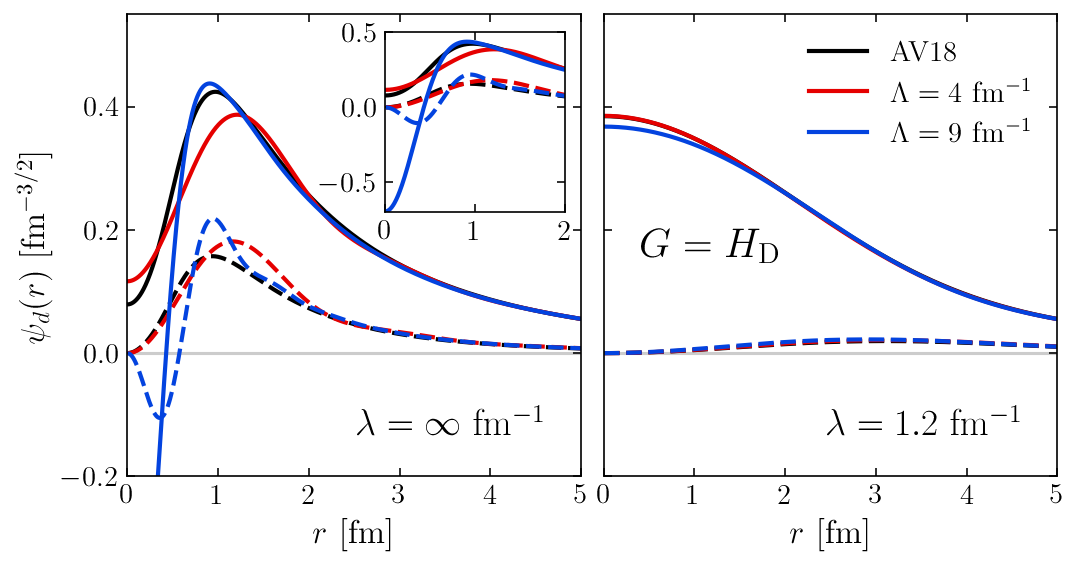

In [48]:
deuteron_wf_rspace(kvnns, kmax, kmid, ntot, generator, lamb, save=True)

## Evolution of other operators

### Plotting functions

In [ ]:
def mpo_contours(
        q, kvnn, channel, kmax, kmid, ntot, generators, lambdas,
        levels_number=61, colorbar_limits=(-0.01,0.01), color_map='turbo',
        axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16,
        generator_label=True, lambda_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = len(generators)
    col_number = len(lambdas)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4*row_number))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)

    # --- Plot initial features --- #
    # Add any lines or shades underneath the data

    # --- Get data --- #

    # --- Set data labels --- #
    # Set label, color, styles, alpha, width, etc. and plot (might need to loop here)

    # --- Plot --- #
    # Call plot(), errorbar(), confourf(), etc

    # --- Plot final features --- #
    # Add any lines or shades over the data

    # --- Axes limits --- #

    # --- Axes labels --- #

    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    # Invert y-axis
    # Get rid of overlapping ticks and axes labels

    # --- Colorbar --- #

    # --- Legend --- #

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    # Set file name and save
    return None

In [ ]:
def r2_operator_3d_plot(
        kmax, kmid, ntot, r_min=0.005, r_max=30.2, dr=0.005, a=1000,
        xy_limits=(0,3), z_limits=(-3000, 3000), xlabel_size=16,
        ylabel_size=16, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    # add 3-D stuff here

    # --- Plot initial features --- #
    # Add any lines or shades underneath the data

    # --- Get data --- #

    # --- Set data labels --- #
    # Set label, color, styles, alpha, width, etc. and plot (might need to loop here)

    # --- Plot --- #
    # Call plot(), errorbar(), confourf(), etc

    # --- Plot final features --- #
    # Add any lines or shades over the data

    # --- Axes limits --- #

    # --- Axes labels --- #

    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    # Invert y-axis
    # Get rid of overlapping ticks and axes labels
    # Adjust like operator_evolution.ipynb

    # --- Colorbar --- #

    # --- Legend --- #

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    # Set file name and save
    return None

In [ ]:
def r2_operator_srg_contributions(
        kvnn, channel, kmax, kmid, ntot, generator, lamb, r_min=0.005,
        r_max=30.2, dr=0.005, levels_number=61, colorbar_limits=(-4.0,4.0),
        color_map='turbo', axes_limits=(0.0,3.0), xlabel_size=16,
        ylabel_size=16, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    col_number = 4
    f, axs = plt.subplots(1, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)

    # --- Plot initial features --- #
    # Add any lines or shades underneath the data

    # --- Get data --- #

    # --- Set data labels --- #
    # Set label, color, styles, alpha, width, etc. and plot (might need to loop here)

    # --- Plot --- #
    # Call plot(), errorbar(), confourf(), etc

    # --- Plot final features --- #
    # Add any lines or shades over the data

    # --- Axes limits --- #

    # --- Axes labels --- #

    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    # Invert y-axis
    # Get rid of overlapping ticks and axes labels

    # --- Colorbar --- #

    # --- Legend --- #

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    # Set file name and save
    return None

In [ ]:
def quantify_srg_changes(
        kvnn, channel, kmax, kmid, ntot, generator, lamb, operator='r2'):
    """
    """

    # --- Get data --- #

    # --- Print table --- #
    return None

In [ ]:
def momentum_distributions(
        kvnn, *generators, eps=-2.22, channel='3S1', x_limits=(0,4),
        y_limits=(1e-5,1e3), xlabel_size=16, ylabel_size=16, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))

    # --- Plot initial features --- #
    # Add any lines or shades underneath the data

    # --- Get data --- #

    # --- Set data labels --- #
    # Set label, color, styles, alpha, width, etc. and plot (might need to loop here)

    # --- Plot --- #
    # Call plot(), errorbar(), confourf(), etc

    # --- Plot final features --- #
    # Add any lines or shades over the data

    # --- Axes limits --- #

    # --- Axes labels --- #

    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    # Invert y-axis
    # Get rid of overlapping ticks and axes labels

    # --- Colorbar --- #

    # --- Legend --- #

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    # Set file name and save
    return None

In [ ]:
def mpo_integrand_contours(
        q, kvnn, channel, kmax, kmid, ntot, generators, lambdas, eps=-2.22,
        levels_number=61, colorbar_limits=(-8, -3), color_map='Blues',
        axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16,
        generator_label=True, lambda_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = len(generators)
    col_number = len(lambdas)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4*row_number))
    
    # Set contour levels
    levels = np.logspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)

    # --- Plot initial features --- #
    # Add any lines or shades underneath the data

    # --- Get data --- #

    # --- Set data labels --- #
    # Set label, color, styles, alpha, width, etc. and plot (might need to loop here)

    # --- Plot --- #
    # Call plot(), errorbar(), confourf(), etc

    # --- Plot final features --- #
    # Add any lines or shades over the data

    # --- Axes limits --- #

    # --- Axes labels --- #

    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    # Invert y-axis
    # Get rid of overlapping ticks and axes labels

    # --- Colorbar --- #

    # --- Legend --- #

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    # Set file name and save
    return None

In [ ]:
def deuteron_radius_error(
        kvnns, kmax, kmid, ntot, generator, lamb, x_limits=(0,6),
        y_limits=(1e-4,1e0), xlabel_size=16, ylabel_size=16, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))

    # --- Plot initial features --- #
    # Add any lines or shades underneath the data

    # --- Get data --- #

    # --- Set data labels --- #
    # Set label, color, styles, alpha, width, etc. and plot (might need to loop here)

    # --- Plot --- #
    # Call plot(), errorbar(), confourf(), etc

    # --- Plot final features --- #
    # Add any lines or shades over the data

    # --- Axes limits --- #

    # --- Axes labels --- #

    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    # Invert y-axis
    # Get rid of overlapping ticks and axes labels

    # --- Colorbar --- #

    # --- Legend --- #

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    # Set file name and save
    return None

In [ ]:
def factorization_ratios(
        k_0, k_i_values, kvnns, channel, kmax, kmid, ntot, generator, lamb,
        x_limits=(0,5), y_limits=(1e-1,1e1), xlabel_size=16, ylabel_size=16,
        kvnn_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    col_number = len(kvnns)
    f, axs = plt.subplots(1, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4))

    # --- Plot initial features --- #
    # Add any lines or shades underneath the data

    # --- Get data --- #
    
    # ... set \lambda = 1 for block-diagonal

    # --- Set data labels --- #
    # Set label, color, styles, alpha, width, etc. and plot (might need to loop here)

    # --- Plot --- #
    # Call plot(), errorbar(), confourf(), etc

    # --- Plot final features --- #
    # Add any lines or shades over the data

    # --- Axes limits --- #

    # --- Axes labels --- #

    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    # Invert y-axis
    # Get rid of overlapping ticks and axes labels

    # --- Colorbar --- #

    # --- Legend --- #

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    # Set file name and save
    return None

In [ ]:
def mpo_ratios(
        q, kvnn_denominator, kvnns_numerator, channel, kmax, kmid, ntot,
        generator, lambdas, x_limits=(0.0,2.5), y_limits=(5e-1, 1e1),
        xlabel_size=16, ylabel_size=16, generator_label=True,
        lambda_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = 2
    col_number = len(lambdas)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4*row_number))

    # --- Plot initial features --- #
    # Add any lines or shades underneath the data

    # --- Get data --- #
    
    # ... hard code kmax=30 for AV18 or kvnn >= 900

    # --- Set data labels --- #
    # Set label, color, styles, alpha, width, etc. and plot (might need to loop here)

    # --- Plot --- #
    # Call plot(), errorbar(), confourf(), etc

    # --- Plot final features --- #
    # Add any lines or shades over the data

    # --- Axes limits --- #

    # --- Axes labels --- #

    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    # Invert y-axis
    # Get rid of overlapping ticks and axes labels

    # --- Colorbar --- #

    # --- Legend --- #

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    # Set file name and save
    return None

In [ ]:
def delta_U_contours(
        kvnns, channel, kmax, kmid, ntot, generators, lamb, levels_number=61,
        colorbar_limits=(-0.2,0.2), color_map='turbo', axes_limits=(0.0,5.0),
        xlabel_size=16, ylabel_size=16, generator_label=True,
        kvnn_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = len(generators)
    col_number = len(kvnns)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4*row_number))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)

    # --- Plot initial features --- #
    # Add any lines or shades underneath the data

    # --- Get data --- #
    
    # ... set \lambda=1 for block-diagonal

    # --- Set data labels --- #
    # Set label, color, styles, alpha, width, etc. and plot (might need to loop here)

    # --- Plot --- #
    # Call plot(), errorbar(), confourf(), etc

    # --- Plot final features --- #
    # Add any lines or shades over the data

    # --- Axes limits --- #

    # --- Axes labels --- #

    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    # Invert y-axis
    # Get rid of overlapping ticks and axes labels

    # --- Colorbar --- #

    # --- Legend --- #

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    # Set file name and save
    return None

### SRG for representative operators

### Connecting to wave function evolution

### Factorization